# Team information

| Team member 1     | Details     | Team member 2     | Details     |
| :---------------- | :---------: | :---------------- | :---------: |
| Name              | John Doe    | Name              | Jane Smith  |
| NUSNet (Exxxxxxx) | E1234567    | NUSNet (Exxxxxxx) | E7654321    |
| Matric (AxxxxxxxZ)| A0123456Z   | Matric (AxxxxxxxZ)| A0654321Z   |

*Note: Fill in your actual details.*

In [1]:
# Connect to Google drive to save your model, etc.,

try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Set a path in your Google Drive to save models and plots
    # Example: '/content/drive/MyDrive/CS4246_A2/'
    SAVE_PATH = '/content/drive/MyDrive/CS4246_A2/' 
    import os
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)
except ModuleNotFoundError:
    print("Not running in Google Colab. Make sure SAVE_PATH is set correctly.")
    # Set a local path if not using Colab
    SAVE_PATH = './cs4246_a2_results/' 
    import os
    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)

# Installation and setup

The gym environment requires an older version numpy (and corresponding packages). <br>
The following cell contains the `requirements.txt` to setup the python environment used in the rest of this notebook.


In [1]:
%%writefile requirements.txt

# Using cloudpickle 2.2.1 compatible with numpy 1.24.2
cloudpickle==2.2.1
contourpy==1.0.7 # Compatible with matplotlib 3.7.1
cycler==0.11.0
filelock==3.9.0 # Common dependency
fonttools==4.39.0
fsspec==2023.1.0 # Common dependency
gym==0.26.2
gym-notices==0.0.8
importlib_metadata==6.0.0
# importlib_resources may cause issues, try without first
Jinja2==3.1.2
kiwisolver==1.4.4
MarkupSafe==2.1.2
matplotlib==3.7.1 # Adjusted version
mpmath==1.2.1
networkx==3.0 # Adjusted version
numpy==1.24.2
# Nvidia packages might differ based on CUDA version, these are examples
# nvidia-cublas-cu11 # Or cu12 depending on your env
# nvidia-cuda-cupti-cu11
# nvidia-cuda-nvrtc-cu11
# nvidia-cuda-runtime-cu11
# nvidia-cudnn-cu11
# nvidia-cufft-cu11
# nvidia-curand-cu11
# nvidia-cusolver-cu11
# nvidia-cusparse-cu11
# nvidia-nccl-cu11
# nvidia-nvtx-cu11
packaging==23.0
pillow==9.4.0
ply==3.11
pygame==2.3.0 # Adjusted version
pyparsing==3.0.9
python-dateutil==2.8.2
six==1.16.0
sympy==1.11.1
torch>=1.13.1 # Ensure torch is compatible
torchaudio>=0.13.1
torchvision>=0.14.1
tqdm==4.64.1
# triton might not be needed unless using specific GPU features
zipp==3.15.0

# Added based on pyRDDLGym setup.py
scipy>=1.8.0
pillow>=9.1.0
matplotlib>=3.5.2
pygame>=2.1.2
gym>=0.26.2

Overwriting requirements.txt


Now install the requirements.

You may be asked to restart the session to load the installed versions of the packages. If so, restart the session and continue using the notebook

In [2]:
!pip install -r requirements.txt --force-reinstall

We will use a discretized version of
the [elevator domain](https://ataitler.github.io/IPPC2023/elevator.html) from the International Planning Competition, 2023.

Install the pyRDDL gym environment using the given repository.

In [3]:
!pip install -q git+https://github.com/tasbolat1/pyRDDLGym.git --force-reinstall

## Install other packages if needed

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import itertools
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import math
import os

# Try importing MovieGenerator, handle potential error if cv2 not found
try:
    from pyRDDLGym.Visualizer.MovieGenerator import MovieGenerator # loads visualizer utilites
except UserWarning as e:
    print(f"Caught UserWarning: {e}")
    print("Movie generation might be disabled if cv2 is missing.")
    MovieGenerator = None # Disable movie generation if problematic
except ImportError as e:
     print(f"Caught ImportError: {e}")
     print("Movie generation might be disabled if dependencies are missing.")
     MovieGenerator = None

from IPython.display import Image, display, clear_output # for displaying gifs in colab
from pyRDDLGym.Elevator import Elevator # imports Discrete Elevator

## Add more imports here as required
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))


# Environment Initialization

In [2]:
## IMPORTANT: Do not change the instance of the environment.
env = Elevator(instance = 5)

print('Discrete environment actions:')
print(env.disc_actions)
print('Continuous environment actions:')
print(env.base_env.action_space)
print(f"Observation space size for the discrete Elevator Environment: {len(env.disc_states)}")
print(f"Number of discrete actions: {env.action_space.n}")

d:\GitHub\cs4246-assignment-2\.venv\Lib\site-packages\pyRDDLGym\Examples d:\GitHub\cs4246-assignment-2\.venv\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with new languag

d:\GitHub\cs4246-assignment-2\.venv\Lib\site-packages\pyRDDLGym\Core\Env\RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


Discrete environment actions:
{0: ('e0_movcurdir_0',), 1: ('e0_movcurdir_1',), 2: ('e0_close_0',), 3: ('e0_close_1',), 4: ('e0_open_0',), 5: ('e0_open_1',)}
Continuous environment actions:
Dict('move-current-dir___e0': Discrete(2), 'open-door___e0': Discrete(2), 'close-door___e0': Discrete(2))
Observation space size for the discrete Elevator Environment: 225280
Number of discrete actions: 6


# Hyperparameters

In [3]:
# Define hyperparameters

## IMPORTANT: <BEGIN> DO NOT CHANGE THIS CODE!
## GENERAL HYPERPARAMS
num_episodes = 3000
## IMPORTANT: <END> DO NOT CHANGE THIS CODE!

## DQN HYPERPARAMS
learning_rate = 1e-4        # Learning rate for Adam optimizer
batch_size = 128            # Number of transitions sampled from the replay buffer
gamma = 0.99                # Discount factor for future rewards
epsilon_start = 1.0         # Starting value of epsilon for epsilon-greedy exploration
epsilon_end = 0.05          # Minimum value of epsilon
epsilon_decay_steps = 50000 # Number of steps over which epsilon decays linearly
tau = 0.005                 # Soft update parameter for target network
buffer_size = 50000         # Maximum size of the replay buffer
target_update_freq = 100    # How often to update the target network (in steps)
min_buffer_size_for_training = 1000 # Minimum buffer size before training starts
hidden_size = 128           # Number of neurons in hidden layers
clip_value = 1.0            # Gradient clipping value (set to None to disable)

# Model Definition

Define your model here. You can rename the class `YourModel` appropriately and use it later in the code.
Note: In case of actor-critic or other models, all components must subclass `nn.Module`

- Your model should take in 11 inputs, which will be derived from the convert_state_to_list function.
- Your model should return 6 values corresponding to the Q-values for each action.

In [4]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(QNetwork, self).__init__()
        # Simple Multi-Layer Perceptron (MLP)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size) # Output Q-values for each action

    def forward(self, x):
        # x will be a tensor with shape [batch_size, input_size]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x) # Linear output layer for Q-values
        return q_values

# Replay Buffer

Stores transitions and allows sampling batches.

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        """Saves a transition."""
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Feature Extraction

In [6]:
## IMPORTANT: DO NOT CHANGE THIS CODE!
env_features = list(env.observation_space.keys())
print(f"Environment features ({len(env_features)}): {env_features}")

def convert_state_to_list(state_desc, env_features):
    out = []
    for i in env_features:
        # Ensure boolean values are converted to floats (0.0 or 1.0)
        value = state_desc[i]
        if isinstance(value, bool):
            out.append(float(value))
        else:
            out.append(value) # Assumes numerical values otherwise
    return out

# Example usage to verify
initial_state = env.reset()
initial_state_desc = env.disc2state(initial_state)
initial_state_list = convert_state_to_list(initial_state_desc, env_features)
print(f"\nInitial state description: {initial_state_desc}")
print(f"Converted initial state list ({len(initial_state_list)}): {initial_state_list}")

Environment features (13): ['num-person-waiting___f0', 'num-person-waiting___f1', 'num-person-waiting___f2', 'num-person-waiting___f3', 'num-person-waiting___f4', 'num-person-in-elevator___e0', 'elevator-dir-up___e0', 'elevator-closed___e0', 'elevator-at-floor___e0__f0', 'elevator-at-floor___e0__f1', 'elevator-at-floor___e0__f2', 'elevator-at-floor___e0__f3', 'elevator-at-floor___e0__f4']

Initial state description: {'num-person-in-elevator___e0': 0, 'elevator-dir-up___e0': True, 'elevator-closed___e0': True, 'elevator-at-floor___e0__f0': True, 'elevator-at-floor___e0__f1': False, 'elevator-at-floor___e0__f2': False, 'elevator-at-floor___e0__f3': False, 'elevator-at-floor___e0__f4': False, 'num-person-waiting___f0': 0, 'num-person-waiting___f1': 0, 'num-person-waiting___f2': 0, 'num-person-waiting___f3': 0, 'num-person-waiting___f4': 0}
Converted initial state list (13): [0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]


# Neural Net Initialization

In [7]:
# Determine input and output sizes from the environment
input_size = len(env_features) # Should be 11 based on template
output_size = env.action_space.n # Number of discrete actions (should be 6)

print(f"Network Input Size: {input_size}")
print(f"Network Output Size: {output_size}")

# Initialize the Q-Network and Target Network
policy_net = QNetwork(input_size, output_size, hidden_size)
target_net = QNetwork(input_size, output_size, hidden_size)
target_net.load_state_dict(policy_net.state_dict()) # Initialize target net with policy net weights
target_net.eval() # Target network is only for inference

# Initialize the optimizer - Adam is a good choice
optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate, amsgrad=True)

# Initialize the replay buffer
memory = ReplayBuffer(buffer_size)

Network Input Size: 13
Network Output Size: 6


In [8]:
# Convert networks to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
policy_net.to(device)
target_net.to(device)

# Define other constructs (replay buffers, etc) as necessary
# Replay buffer 'memory' already initialized above

Using device: cpu


QNetwork(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

## Gradient Clipping (Optional, using torch's version)

In [9]:
# Define a function for gradient clipping (using PyTorch's built-in)
def clip_grads_pytorch(model, max_norm):
    if max_norm is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# We will call clip_grads_pytorch(policy_net, clip_value) after loss.backward()

# Live Plotting Setup

In [10]:
# Create a figure for plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 7))
plt.ion() # Turn on interactive mode

# Lists to store rewards and episode numbers
rewards_list = []
episodes_list = [] # Store episode numbers for x-axis
losses_list = [] # Optional: store losses

def exponential_smoothing(data, alpha=0.1):
    """Compute exponential smoothing."""
    if not data: return []
    smoothed = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        st = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(st)
    return smoothed

def live_plot(data_dict, figure, axes, ylabel="Total Rewards", title="Training Progress"):
    """Plot the live graph."""
    try:
      clear_output(wait=True)
      axes.clear()
      colors = ['yellow', 'purple', 'blue', 'green'] # Add more colors if needed
      color_idx = 0

      for label, data_info in data_dict.items():
          episodes = data_info['episodes']
          values = data_info['values']
          plot_smoothed = data_info.get('smooth', False)
          y_label = data_info.get('ylabel', ylabel) # Allow specific y-label per plot

          if not episodes or not values: continue # Skip if no data

          # Plot raw data
          axes.plot(episodes, values, label=label, color=colors[color_idx % len(colors)], linestyle='--' if plot_smoothed else '-', alpha=0.6 if plot_smoothed else 1.0)
          color_idx += 1

          # Compute and plot moving average if requested
          if plot_smoothed:
              smoothed_values = exponential_smoothing(values)
              if smoothed_values:
                  axes.plot(episodes, smoothed_values, label=f"Smoothed {label}", linestyle="-", color=colors[color_idx % len(colors)], linewidth=2)
                  color_idx += 1

      axes.set_xlabel("Episode")
      axes.set_ylabel(y_label)
      axes.set_title(title)
      axes.legend(loc='upper left')
      axes.grid(True)
      display(figure)
      plt.pause(0.01) # Small pause to allow plot to update
    except Exception as e:
        print(f"Plotting error: {e}") # Catch potential display errors

# RL Algorithm - DQN Specific Functions

In [11]:
# Define the loss calculation function (part of the optimization step)
def optimize_model():
    if len(memory) < batch_size or len(memory) < min_buffer_size_for_training:
        return None # Not enough samples yet

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda d: not d, batch.done)), device=device, dtype=torch.bool)
    # Ensure next_states that are None (for terminal states) are handled
    non_final_next_states_list = [s for s in batch.next_state if s is not None]

    # Check if there are any non-final states before creating tensor
    if non_final_next_states_list:
      non_final_next_states = torch.stack(non_final_next_states_list, dim=0)
    else:
      # If all states in the batch are terminal, create an empty tensor of the correct shape
      non_final_next_states = torch.empty((0, input_size), device=device, dtype=torch.float32)

    state_list = [s for s in batch.state] # Explicitly create list
    state_batch = torch.stack(state_list, dim=0) # Shape (batch_size, 13)

    action_batch = torch.cat(batch.action) # Shape (batch_size, 1)
    reward_batch = torch.cat(batch.reward) # Shape (batch_size,)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    if non_final_next_states_list:
        with torch.no_grad():
            # DDQN change: Use policy_net to select the best action for the next state
            policy_q_next = policy_net(non_final_next_states)
            best_actions = policy_q_next.max(1)[1].unsqueeze(1) # Get indices of best actions

            # DDQN change: Use target_net to evaluate the Q-value of that chosen action
            q_next = target_net(non_final_next_states).gather(1, best_actions)
            next_state_values[non_final_mask] = q_next.squeeze(1) # Remove the extra dimension added by gather

    # Compute the expected Q values (Bellman target)
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss (less sensitive to outliers than MSE)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    clip_grads_pytorch(policy_net, clip_value)

    optimizer.step()

    return loss.item()

In [12]:
steps_done = 0

def choose_action(state_tensor):
    global steps_done
    # Linearly decay epsilon
    if epsilon_decay_steps > 0:
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
            math.exp(-1. * steps_done / epsilon_decay_steps) # Exponential decay is often better
        # Linear decay: max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * steps_done / epsilon_decay_steps)
    else:
        epsilon = epsilon_end # If no decay steps, use end value

    steps_done += 1

    # Epsilon-greedy action selection
    if random.random() > epsilon:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q_values = policy_net(state_tensor.unsqueeze(0)) # Add batch dimension
            action = q_values.max(1)[1].view(1, 1)
            return action.item() # Return the integer action
    else:
        # Choose a random action
        return random.randrange(output_size)

## Training loop with live plotting

Use the graph generated here in your pdf submission.

In [13]:
SAVE_PATH = 'save'

In [14]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 7))
plt.ion() # Turn on interactive mode

# Reset lists for new training run
rewards_list = []
episodes_list = []
losses_list = []
current_loss = 0.0 # Track loss for display
steps_done = 0 # Reset step counter for epsilon decay

# Create a tqdm progress bar
progress_bar = tqdm.tqdm(range(num_episodes), desc='Training Progress', postfix={'Total Reward': 0, 'Avg Loss': 0, 'Epsilon': epsilon_start})

# RL algorithm training loop
for episode in progress_bar:
    total_reward = 0
    state = env.reset()
    state_desc = env.disc2state(state)
    state_list = convert_state_to_list(state_desc, env_features)
    state_tensor = torch.tensor(state_list, dtype=torch.float32, device=device)

    episode_losses = [] # Track losses within an episode

    # The environment runs for a fixed horizon (env.horizon)
    for t in range(env.horizon):

        action_int = choose_action(state_tensor)
        # Need action as tensor for buffer
        action_tensor = torch.tensor([[action_int]], device=device, dtype=torch.long)

        # Take the chosen action and observe the next state and reward
        next_state, reward, done, info = env.step(action_int)
        total_reward += reward
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)

        # Convert the next state to the suitable format for the network
        if not done:
            next_state_desc = env.disc2state(next_state)
            next_state_list = convert_state_to_list(next_state_desc, env_features)
            next_state_tensor = torch.tensor(next_state_list, dtype=torch.float32, device=device)
        else:
            next_state_tensor = None # Indicate terminal state

        # Store the transition in memory
        # Ensure state_tensor is used, not the list
        memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor, done)

        # Move to the next state
        state_tensor = next_state_tensor
        state = next_state # Keep track of discrete state if needed

        # Perform one step of the optimization (on the policy network)
        loss_value = optimize_model()
        if loss_value is not None:
           episode_losses.append(loss_value)
           current_loss = loss_value # Update loss for display

        # Soft update of the target network's weights
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        target_net.load_state_dict(target_net_state_dict)

        # If episode finished (though env runs for fixed horizon)
        if done:
            break

    # After episode calculations
    rewards_list.append(total_reward)
    episodes_list.append(episode)
    if episode_losses:
        losses_list.append(np.mean(episode_losses))
    else:
        losses_list.append(None) # Append None if no training happened

    # Update plot (e.g., every 10 episodes)
    if episode % 10 == 0 or episode == num_episodes - 1:
      plot_data = {
          'Total Reward': {'episodes': episodes_list, 'values': rewards_list, 'smooth': True, 'ylabel': 'Total Reward'}
          # Optionally plot loss
          # 'Average Loss': {'episodes': episodes_list, 'values': [l for l in losses_list if l is not None], 'smooth': True, 'ylabel': 'Average Loss'}
      }
      live_plot(plot_data, fig, ax, title=f'Training Progress (Episode {episode+1}/{num_episodes})')

    # Calculate current epsilon for display
    current_epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * steps_done / epsilon_decay_steps) if epsilon_decay_steps > 0 else epsilon_end

    # Update progress bar postfix
    progress_bar.set_postfix({'Total Reward': f'{total_reward:.2f}',
                              'Avg Loss': f'{current_loss:.4f}' if current_loss is not None else 'N/A',
                              'Epsilon': f'{current_epsilon:.3f}',
                              'Steps': steps_done})

    # Saving the model periodically
    if episode % 500 == 0 or episode == num_episodes - 1:
      model_save_path = os.path.join(SAVE_PATH, f'dqn_elevator_model_ep{episode}.pt')
      torch.save(policy_net.state_dict(), model_save_path)
      print(f"\nModel saved to {model_save_path}")

# Final plot update after loop ends
plot_data = {
    'Total Reward': {'episodes': episodes_list, 'values': rewards_list, 'smooth': True, 'ylabel': 'Total Reward'}
}
live_plot(plot_data, fig, ax, title=f'Training Completed ({num_episodes} Episodes)')
plt.ioff() # Turn off interactive mode

# Save the final plot
plot_save_path = os.path.join(SAVE_PATH, 'dqn_training_rewards.png')
fig.savefig(plot_save_path)
print(f"\nFinal plot saved to {plot_save_path}")
plt.show()

<Figure size 1200x700 with 1 Axes>


Final plot saved to save\dqn_training_rewards.png


C:\Users\ezrat\AppData\Local\Temp\ipykernel_7996\134099025.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Compute the mean rewards

Report the mean rewards obtained over the last 100 episodes in your pdf submission

In [15]:
# Calculate mean reward over the last 100 episodes
if len(rewards_list) >= 100:
    mean_reward_last_100 = np.mean(rewards_list[-100:])
else:
    mean_reward_last_100 = np.mean(rewards_list) # Mean over all if less than 100 episodes

print(f"\nMean Reward over last 100 episodes: {mean_reward_last_100:.2f}")

# close the environment
env.close()


Mean Reward over last 100 episodes: -127.34


# Evaluation

Evaluate the trained policy without exploration.

In [16]:
def evaluate_policy(policy_net, env, num_eval_episodes=10, render=False, render_path=None):
    policy_net.eval()  # Set the network to evaluation mode
    total_rewards = []
    env_features = list(env.observation_space.keys())

    # Initialize visualizer if rendering
    if render and MovieGenerator is not None and render_path is not None:
        # Need to re-initialize env with rendering enabled for evaluation
        eval_env = Elevator(instance=5, is_render=True, render_path=render_path)
        print(f"Rendering evaluation to {render_path}")
    else:
        eval_env = env  # Use the original env if not rendering
        render = False  # Ensure render is False if MovieGenerator failed

    print(f"\nStarting evaluation for {num_eval_episodes} episodes...")
    for episode in range(num_eval_episodes):
        state = eval_env.reset()
        episode_reward = 0

        for t in range(eval_env.horizon):
            state_desc = eval_env.disc2state(state)
            state_list = convert_state_to_list(state_desc, env_features)
            state_tensor = torch.tensor(state_list, dtype=torch.float32, device=device).unsqueeze(0)

            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.max(1)[1].item()  # Choose action with highest Q-value

            next_state, reward, done, _ = eval_env.step(action)

            if render:
                eval_env.render()

            episode_reward += reward
            state = next_state

            if done:
                break

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode + 1}/{num_eval_episodes}, Reward: {episode_reward:.2f}")

    if render:
        try:
            eval_env.save_render()
            gif_path = os.path.join(render_path, 'elevator.gif')
            print(f"Evaluation GIF saved to {gif_path}")
            
            # Check if the file exists before trying to display it
            if os.path.exists(gif_path):
                try:
                    display(Image(filename=gif_path))
                except NameError:
                    print("Cannot display image directly. Check the saved file.")
            else:
                print(f"Warning: GIF file was not created at {gif_path}.")
        except Exception as e:
            print(f"Error during rendering: {e}")
            print("Continuing with evaluation results...")
        
        eval_env.close()

    mean_eval_reward = np.mean(total_rewards)
    std_eval_reward = np.std(total_rewards)
    print(f"\nEvaluation Results ({num_eval_episodes} episodes):")
    print(f"Mean Reward: {mean_eval_reward:.2f} +/- {std_eval_reward:.2f}")
    policy_net.train()  # Set the network back to training mode
    return mean_eval_reward


d:\GitHub\cs4246-assignment-2\.venv\Lib\site-packages\pyRDDLGym\Examples d:\GitHub\cs4246-assignment-2\.venv\Lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with new languag

d:\GitHub\cs4246-assignment-2\.venv\Lib\site-packages\pyRDDLGym\Core\Env\RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


Rendering evaluation to save

Starting evaluation for 5 episodes...
Evaluation Episode 1/5, Reward: 62.25


d:\GitHub\cs4246-assignment-2\.venv\Lib\site-packages\pyRDDLGym\Visualizer\MovieGenerator.py:83: UserWarning: removed 201 temporary files at save\Elevators_*.png
  self.reset()


Evaluation Episode 2/5, Reward: 62.25
Evaluation Episode 3/5, Reward: -8.25
Evaluation Episode 4/5, Reward: 128.25
Evaluation Episode 5/5, Reward: 23.25
Evaluation GIF saved to save\elevator.gif


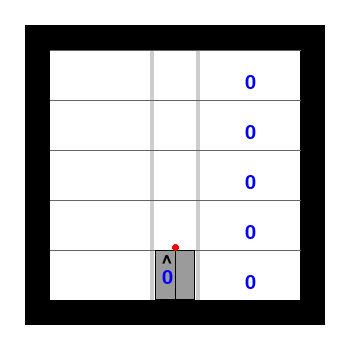


Evaluation Results (5 episodes):
Mean Reward: 53.55 +/- 45.76


53.55

In [17]:
best_model_path = os.path.join(SAVE_PATH, 'dqn_elevator_model_ep2999.pt')
policy_net.load_state_dict(torch.load(best_model_path))
evaluate_policy(policy_net, env, num_eval_episodes=5, render=True, render_path=SAVE_PATH)